Iteration 0: Cost (MSE) = 0.1426423, Learning Rate = 0.01


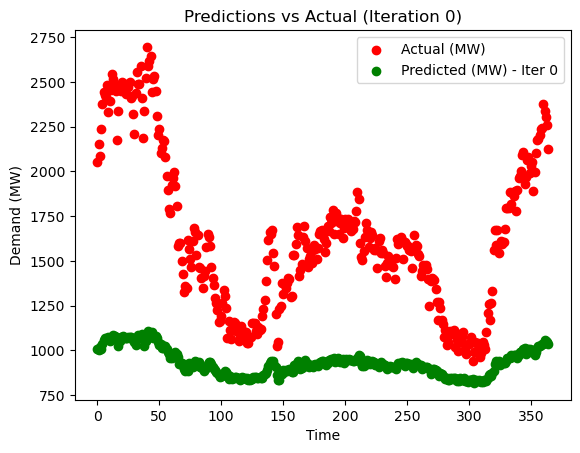

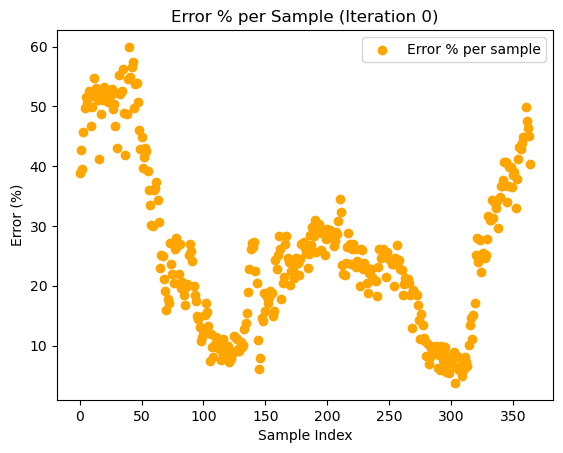

Iteration 1: Cost (MSE) = 0.1341642, Learning Rate = 0.01
Iteration 2: Cost (MSE) = 0.1258984, Learning Rate = 0.01
Iteration 3: Cost (MSE) = 0.1178586, Learning Rate = 0.01
Iteration 4: Cost (MSE) = 0.1100573, Learning Rate = 0.01
Iteration 5: Cost (MSE) = 0.1025062, Learning Rate = 0.01
Iteration 6: Cost (MSE) = 0.0952155, Learning Rate = 0.01
Iteration 7: Cost (MSE) = 0.0881943, Learning Rate = 0.01
Iteration 8: Cost (MSE) = 0.0814506, Learning Rate = 0.01
Iteration 9: Cost (MSE) = 0.0749907, Learning Rate = 0.01
Iteration 10: Cost (MSE) = 0.0688197, Learning Rate = 0.01
Iteration 11: Cost (MSE) = 0.0629415, Learning Rate = 0.01
Iteration 12: Cost (MSE) = 0.0573582, Learning Rate = 0.01
Iteration 13: Cost (MSE) = 0.0520710, Learning Rate = 0.01
Iteration 14: Cost (MSE) = 0.0470796, Learning Rate = 0.01
Iteration 15: Cost (MSE) = 0.0423826, Learning Rate = 0.01
Iteration 16: Cost (MSE) = 0.0379776, Learning Rate = 0.01
Iteration 17: Cost (MSE) = 0.0338612, Learning Rate = 0.01
Iterat

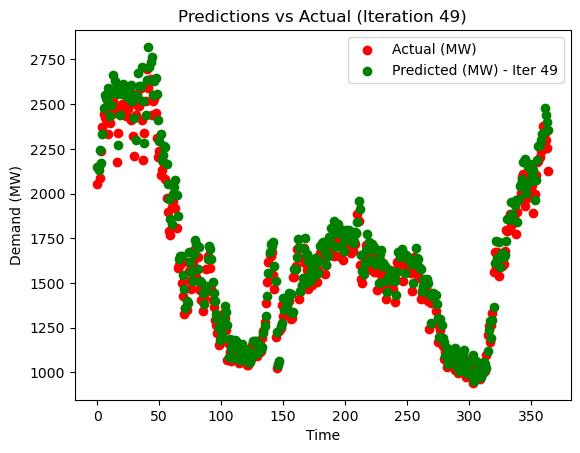

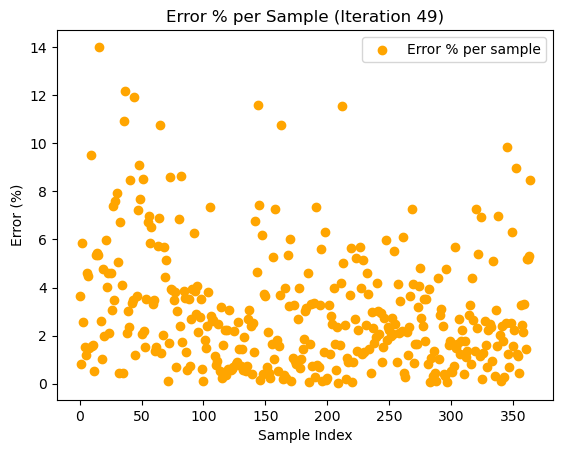

Final parameters after training:
[[-0.18708318  0.10941644  0.53938197  0.16414545  0.21883758 -0.07449171]]


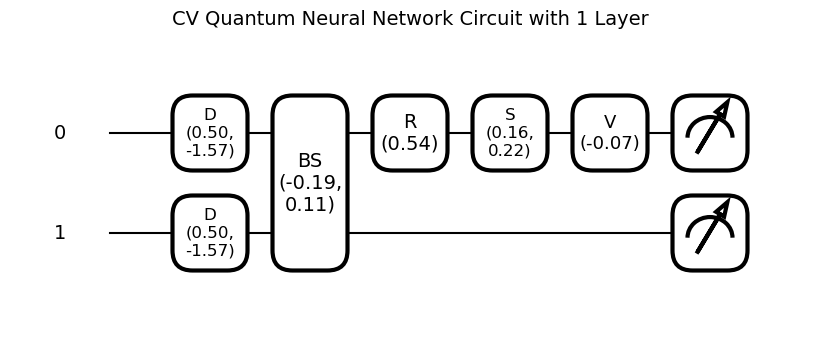

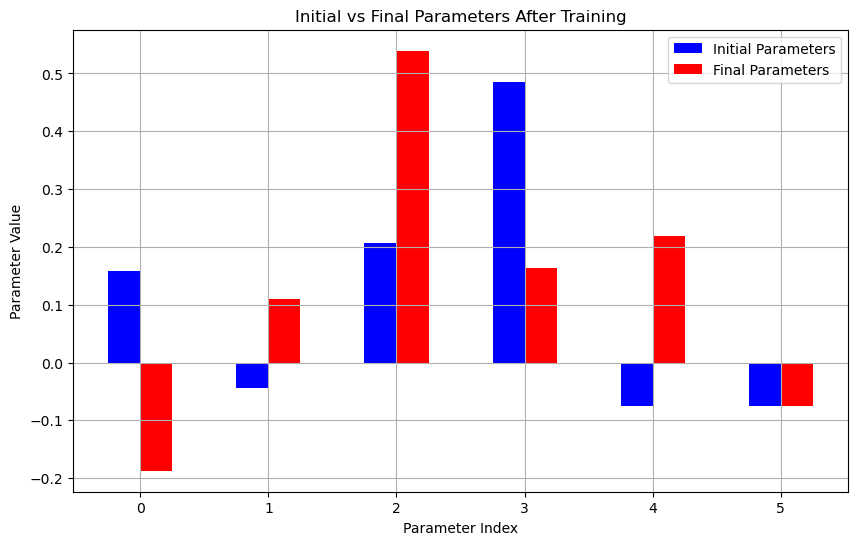

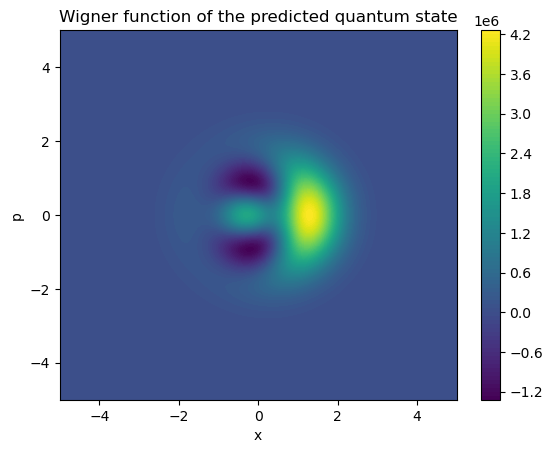

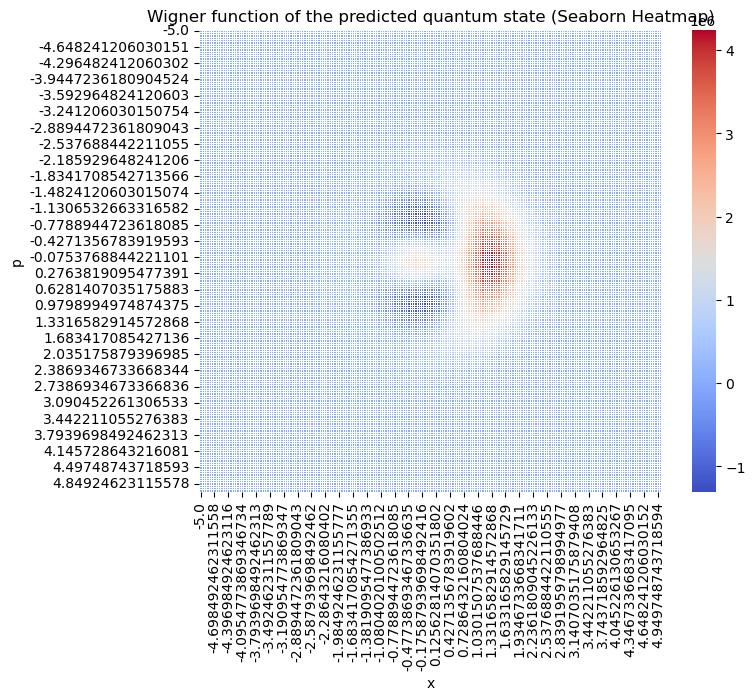

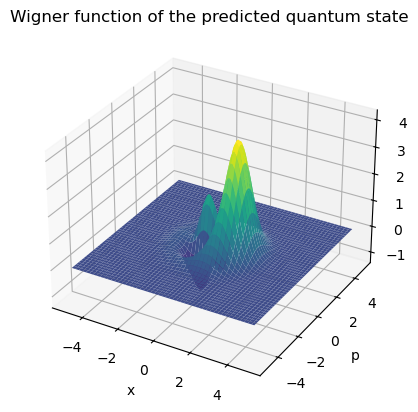

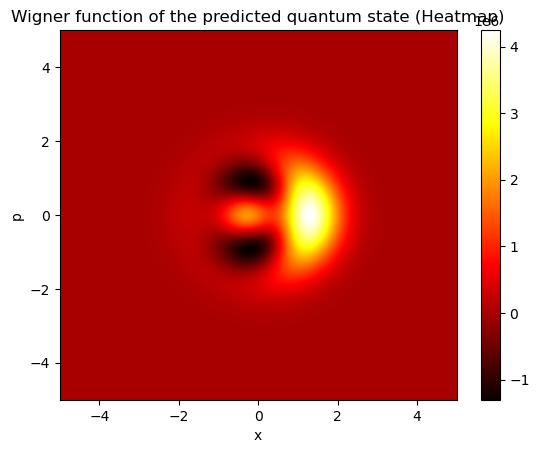

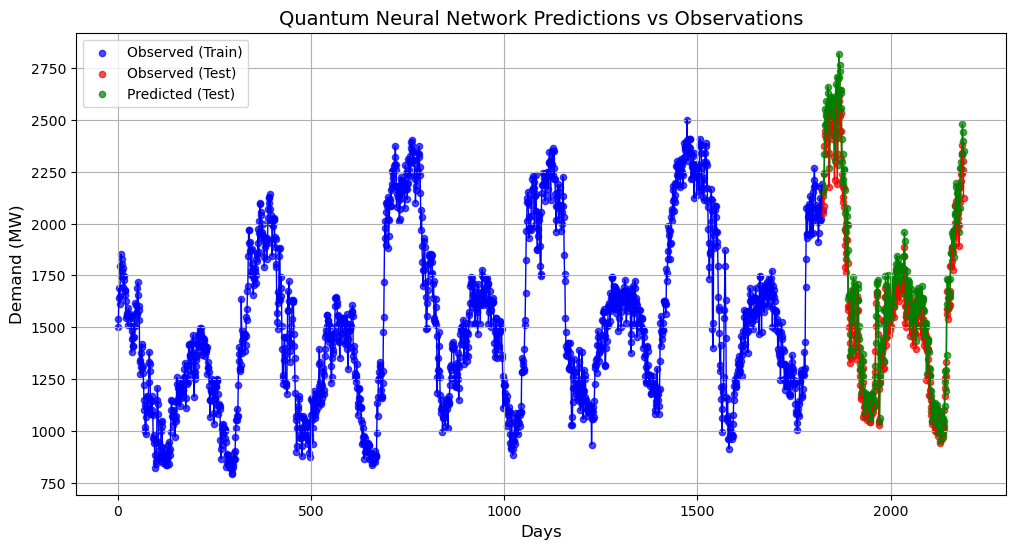

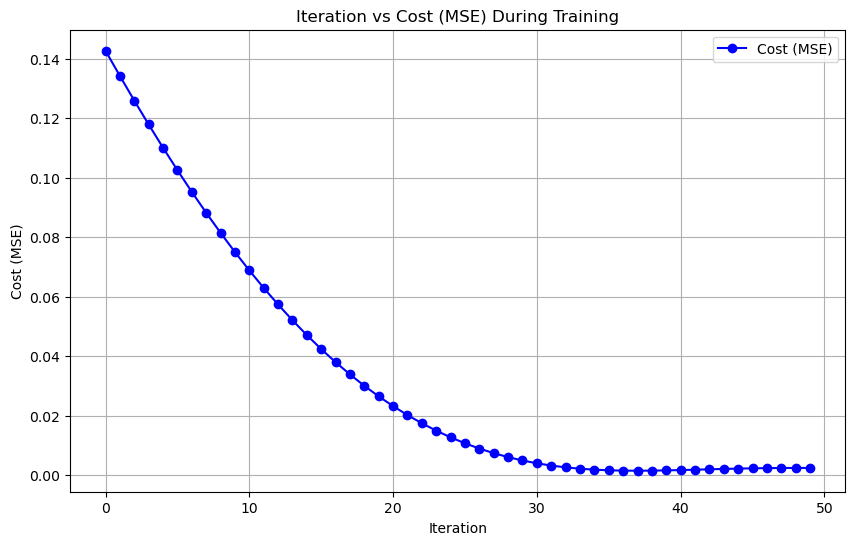

In [1]:
# Note:
# The full plots and code are in the zipped folder.

# The Proposed two-wire simplification 2
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from qutip import Qobj, wigner
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

LoadData = pd.read_excel(r'C:\Users\ismae\A1_Pennylane\LF\ErbilLoad.xlsx')
LoadData['average demand'] = pd.to_numeric(LoadData['average demand'], errors='coerce')

X = np.array(LoadData['average demand'].values[:-1], requires_grad=False)
Y = np.array(LoadData['average demand'].values[1:], requires_grad=False)

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.transform(Y.reshape(-1, 1)).flatten()

train_samples = 5 * 365
test_samples = 1 * 365

X_train = X_normalized[:train_samples]
Y_train = Y_normalized[:train_samples]
X_test = X_normalized[train_samples:train_samples + test_samples]
Y_test = Y_normalized[train_samples:train_samples + test_samples]

cutoff_dim = 12
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=cutoff_dim)

def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0, 1])
    qml.Rotation(v[2], wires=0)
    qml.Squeezing(v[3], v[4], wires=0)
    qml.CubicPhase(v[5], wires=0)

@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    qml.Displacement(x, -np.pi/2, wires=0)
    qml.Displacement(x, -np.pi/2, wires=1)
    for v in var:
        layer(v)
    return qml.expval(qml.X(0)), qml.expval(qml.X(1))

def square_loss(labels, predictions):
    return np.mean((np.array(labels) - np.array(predictions).flatten()) ** 2)

def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x)[0] for x in features]
    return square_loss(labels, preds)

np.random.seed(42)
num_layers = 1
var_init = 1 / (1 * np.pi) * np.random.randn(num_layers, 6)

initial_learning_rate = 0.01
learning_rate = initial_learning_rate
opt = AdamOptimizer(stepsize=learning_rate, beta1=0.9, beta2=0.999)

var = var_init
iterations = 50
costs = []

for it in range(iterations):
    var, _cost = opt.step_and_cost(lambda v: cost(v, X_train, Y_train), var)
    costs.append(_cost)
    
    # Print results for each iteration
    print(f"Iteration {it}: Cost (MSE) = {_cost:.7f}, Learning Rate = {learning_rate}")

    # Plot only the first and last iteration
    if it == 0 or it == iterations - 1:
        predictions_test_encoded = [quantum_neural_net(var, x_)[0] for x_ in X_test]
        predictions_test_original_scale = scaler.inverse_transform(np.array(predictions_test_encoded).reshape(-1, 1)).flatten()
        Y_test_original_scale = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

        error = Y_test_original_scale - predictions_test_original_scale
        rmse = np.sqrt(np.mean(error ** 2))
        rmse_percentage = (rmse / np.mean(Y_test_original_scale)) * 100

        plt.figure()
        plt.scatter(range(test_samples), Y_test_original_scale, color='red', label='Actual (MW)')
        plt.scatter(range(test_samples), predictions_test_original_scale, color="green", label=f'Predicted (MW) - Iter {it}')
        plt.xlabel("Time")
        plt.ylabel("Demand (MW)")
        plt.legend()
        plt.title(f"Predictions vs Actual (Iteration {it})")
        plt.show()

        error_percentage = (np.abs(error) / np.max(Y_test_original_scale)) * 100
        plt.figure()
        plt.scatter(range(test_samples), error_percentage, color='orange', label='Error % per sample', marker='o', linestyle='-')
        plt.xlabel("Sample Index")
        plt.ylabel("Error (%)")
        plt.title(f"Error % per Sample (Iteration {it})")
        plt.legend()
        plt.show()

print("Final parameters after training:")
print(var)

# Plot the final results
x_example = 0.5
qml.draw_mpl(quantum_neural_net, decimals=2)(var, x_example)
plt.title("CV Quantum Neural Network Circuit with 1 Layer", fontsize=14)
plt.show()

# Plot initial vs final parameters
bar_width = 0.25
indices = np.arange(var_init.size)
plt.figure(figsize=(10, 6))
plt.bar(indices - bar_width/2, var_init.flatten(), bar_width, label='Initial Parameters', color='blue')
plt.bar(indices + bar_width/2, var.flatten(), bar_width, label='Final Parameters', color='red')
plt.xlabel('Parameter Index')
plt.ylabel('Parameter Value')
plt.title('Initial vs Final Parameters After Training')
plt.legend()
plt.grid(True)
plt.show()

state = Qobj([[predictions_test_original_scale[0]], [predictions_test_original_scale[1]], [predictions_test_original_scale[2]], [0], [0]])  
xvec = np.linspace(-5, 5, 200)
W = wigner(state, xvec, xvec)

plt.figure()
plt.contourf(xvec, xvec, W, 100)
plt.colorbar()
plt.title('Wigner function of the predicted quantum state')
plt.xlabel('x')
plt.ylabel('p')
plt.show()

W_df = pd.DataFrame(W, index=xvec, columns=xvec)

plt.figure(figsize=(8, 6))
sns.heatmap(W_df, cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Wigner function of the predicted quantum state (Seaborn Heatmap)')
plt.xlabel('x')
plt.ylabel('p')
plt.show()

X, Y = np.meshgrid(xvec, xvec)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, W, cmap='viridis')
ax.set_title('Wigner function of the predicted quantum state')
ax.set_xlabel('x')
ax.set_ylabel('p')
ax.set_zlabel('W(x, p)')
plt.show()

plt.imshow(W, extent=(-5, 5, -5, 5), cmap='hot', origin='lower', aspect='auto')
plt.colorbar()
plt.title('Wigner function of the predicted quantum state (Heatmap)')
plt.xlabel('x')
plt.ylabel('p')
plt.show()

total_days = 6 * 365

plt.figure(figsize=(12, 6), facecolor='white')
plt.scatter(range(train_samples), scaler.inverse_transform(Y_train.reshape(-1, 1)), label='Observed (Train)', color='blue', s=20, marker='o', alpha=0.7)
plt.plot(range(train_samples), scaler.inverse_transform(Y_train.reshape(-1, 1)), color='blue', linewidth=1)
plt.scatter(range(train_samples, total_days), scaler.inverse_transform(Y_test.reshape(-1, 1)), label='Observed (Test)', color='red', s=20, marker='o', alpha=0.7)
plt.plot(range(train_samples, total_days), scaler.inverse_transform(Y_test.reshape(-1, 1)), color='red', linewidth=1)
plt.scatter(range(train_samples, total_days), predictions_test_original_scale, label='Predicted (Test)', color='green', s=20, marker='o', alpha=0.7)
plt.plot(range(train_samples, total_days), predictions_test_original_scale, color='green', linewidth=1)
plt.title('Quantum Neural Network Predictions vs Observations', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Demand (MW)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(True)
plt.show()

predictions_df = pd.DataFrame({'Actual': Y_test_original_scale, 'Predicted': predictions_test_original_scale})
predictions_df.to_csv(r'C:\Users\ismae\A1_Pennylane\LF\Predictions_QNN.csv', index=False)

# Plot the cost during training
plt.figure(figsize=(10, 6))
plt.plot(range(iterations), costs, marker='o', linestyle='-', color='b', label='Cost (MSE)')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Iteration vs Cost (MSE) During Training')
plt.legend()
plt.grid(True)
plt.show()

Optimized_weights_simplification_2 = var.copy()
file_path = r'C:\Users\ismae\A1_Pennylane\LF\Optimized_weights_simplification_2.npy'
np.save(file_path, Optimized_weights_simplification_2)


Iteration 0: Cost = 0.0373890, RMSE% = 14.37%, Learning Rate = 0.01
Iteration 1: Cost = 0.0301560, RMSE% = 10.48%, Learning Rate = 0.0095
Iteration 2: Cost = 0.0250822, RMSE% = 7.23%, Learning Rate = 0.009025
Iteration 3: Cost = 0.0223969, RMSE% = 5.52%, Learning Rate = 0.00857375
Iteration 4: Cost = 0.0215424, RMSE% = 6.66%, Learning Rate = 0.0081450625
Iteration 5: Cost = 0.0213294, RMSE% = 5.37%, Learning Rate = 0.007737809374999998
Iteration 6: Cost = 0.0208012, RMSE% = 6.24%, Learning Rate = 0.007350918906249998
Iteration 7: Cost = 0.0204808, RMSE% = 5.27%, Learning Rate = 0.006983372960937498
Iteration 8: Cost = 0.0201688, RMSE% = 6.01%, Learning Rate = 0.006634204312890623
Iteration 9: Cost = 0.0198294, RMSE% = 5.37%, Learning Rate = 0.006302494097246091
Iteration 10: Cost = 0.0193892, RMSE% = 5.81%, Learning Rate = 0.005987369392383787
Iteration 11: Cost = 0.0190783, RMSE% = 5.45%, Learning Rate = 0.005688000922764597
Iteration 12: Cost = 0.0186426, RMSE% = 5.27%, Learning Rate

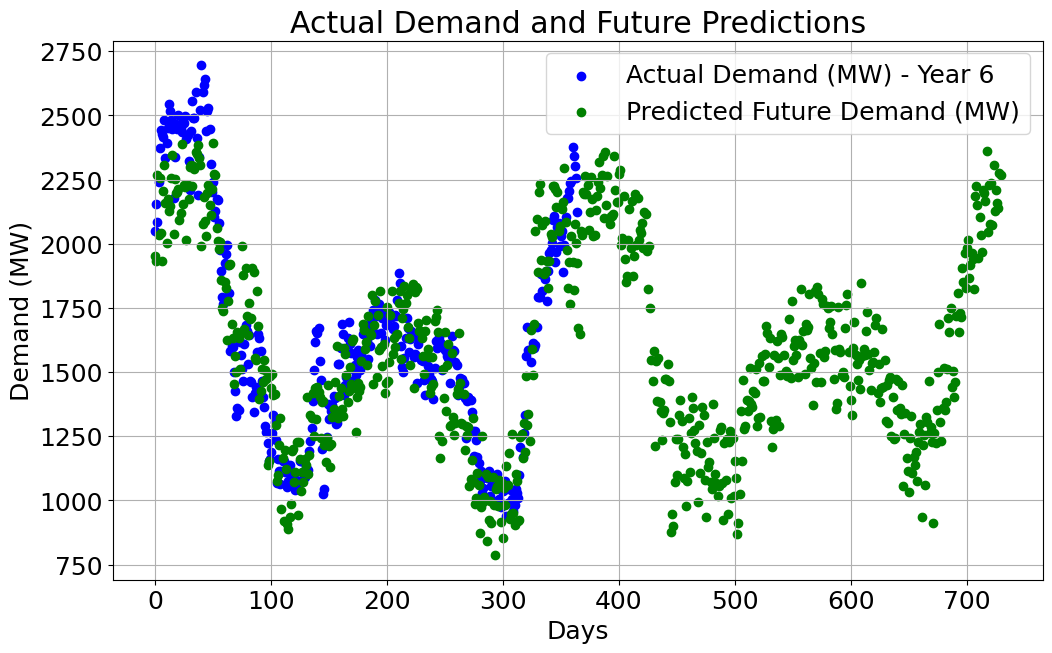

In [1]:
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load Data and Preprocessing
LoadData = pd.read_excel(r'C:\Users\ismae\OneDrive\Documents\MATLAB\Quantum Computing\LF\Programs_IJEEE\1_Model_1\ErbilLoad.xlsx')
LoadData['average demand'] = pd.to_numeric(LoadData['average demand'], errors='coerce')

# Extract features (X) and labels (Y)
X = np.array(LoadData['average demand'].values[:-1], requires_grad=False)
Y = np.array(LoadData['average demand'].values[1:], requires_grad=False)

# Normalize Data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.transform(Y.reshape(-1, 1)).flatten()

# Partition Data
train_samples = 5 * 365
test_samples = 1 * 365

# Generate augmented training data
def augment_data(X, Y, num_augmentations=1, noise_level=0.1):
    augmented_X = []
    augmented_Y = []
    for i in range(num_augmentations):
        noise = np.random.uniform(-noise_level, noise_level, size=X.shape)
        augmented_X.append(X + noise)
        augmented_Y.append(Y)
    return np.concatenate(augmented_X), np.concatenate(augmented_Y)

# Augment training data
X_train_augmented, Y_train_augmented = augment_data(X_normalized[:train_samples], Y_normalized[:train_samples])

# Use augmented data for training
X_train = X_train_augmented
Y_train = Y_train_augmented

# Original test data remains the same
X_test = X_normalized[train_samples:train_samples + test_samples]
Y_test = Y_normalized[train_samples:train_samples + test_samples]

# Pad X_train and X_test with a second feature (e.g., zeros)
X_train = np.column_stack((X_train, np.zeros_like(X_train)))
X_test = np.column_stack((X_test, np.zeros_like(X_test)))

# Define the quantum device with adjustable cutoff dimension
cutoff_dim = 12
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=cutoff_dim)

# Define a quantum layer with D, R, S, Kerr, and BS including variable entanglement and variational gates
def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0, 1])
    qml.Rotation(v[2], wires=0)
    qml.Squeezing(v[3], v[4], wires=0)
    qml.CubicPhase(v[5], wires=0)  # Nonlinear cubic phase shift

# Define the quantum neural network
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode both input features into the quantum state (average demand and temperature)
    qml.Displacement(x[0], -np.pi/2, wires=0)  # Encode average demand on wire 0
    qml.Displacement(x[1], -np.pi/2, wires=1)  # Encode temperature on wire 1
    for v in var:
        layer(v)
    return qml.expval(qml.X(0)), qml.expval(qml.X(1))

# Define loss function
def square_loss(labels, predictions):
    return np.mean((np.array(labels) - np.array(predictions).flatten()) ** 2)

# Define cost function with L2 regularization
def cost(var, features, labels, reg_lambda=0.01):
    preds = [quantum_neural_net(var, x=x)[0] for x in features]
    loss = square_loss(labels, preds)
    # Add L2 regularization
    reg = reg_lambda * np.sum([np.sum(v ** 2) for v in var])
    return loss + reg

# Initialize weights and optimizer
np.random.seed(0)
num_layers = 2
var_init = 1 / (1 * np.pi) * np.random.randn(num_layers, 6)

initial_learning_rate = 0.01
learning_rate = initial_learning_rate
opt = AdamOptimizer(stepsize=learning_rate, beta1=0.9, beta2=0.999)
var = var_init

iterations = 50  # Increase the number of iterations
costs = []

# Early stopping parameters
best_rmse = float('inf')
patience = 5  # Number of iterations to wait for improvement
wait = 0

# Training loop
for it in range(iterations):
    var, _cost = opt.step_and_cost(lambda v: cost(v, X_train, Y_train), var)
    costs.append(_cost)
    
    # Predictions on test data
    predictions_test_encoded = [quantum_neural_net(var, x=x_)[0] for x_ in X_test]
    predictions_test_original_scale = scaler.inverse_transform(
        np.array(predictions_test_encoded).reshape(-1, 1)
    ).flatten()
    Y_test_original_scale = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

    error = Y_test_original_scale - predictions_test_original_scale
    rmse = np.sqrt(np.mean(error ** 2))
    rmse_percentage = (rmse / np.mean(Y_test_original_scale)) * 100

    # Early stopping check
    if rmse < best_rmse:
        best_rmse = rmse
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at iteration {it}")
            break

    # Learning rate decay
    learning_rate = initial_learning_rate * (0.95 ** it)  # Decay learning rate
    opt = AdamOptimizer(stepsize=learning_rate, beta1=0.9, beta2=0.999)
    
    print(f"Iteration {it}: Cost = {_cost:.7f}, RMSE% = {rmse_percentage:.2f}%, Learning Rate = {learning_rate}")

# Function to predict future demand
def predict_future(var, X_initial, window_size, days):
    future_predictions = []
    if len(X_initial) < window_size:
        raise ValueError("X_initial must have at least 'window_size' elements.")
    window = list(X_initial[-window_size:])
    for _ in range(days):
        input_data = window[-365*3]
        prediction_encoded = quantum_neural_net(var, x=input_data)[0]
        prediction_original_scale = scaler.inverse_transform(
            np.array(prediction_encoded).reshape(-1, 1)
        ).flatten()[0]
        future_predictions.append(prediction_original_scale)
        window.pop(0)
        window.append(scaler.transform([[prediction_original_scale]]).flatten()[0])
    return future_predictions

# Set the number of days and window size before calling the function
future_days = 365 * 2
window_size = 365 * 5

# Generate future predictions
future_predictions = predict_future(var, X_train, window_size=window_size, days=future_days)
Y_test_original_scale = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1)).flatten()

# Prepare data for plotting
x_axis_actual = range(len(Y_test_original_scale))  # Actual data
x_axis_predictions = range(len(future_predictions))  # Future predictions
Y_combined = list(Y_test_original_scale) + future_predictions

# Increase font size globally
plt.rcParams.update({'font.size': 18})

# Plot actual and predicted demand
plt.figure(figsize=(12, 7))
plt.scatter(x_axis_actual, Y_test_original_scale, label="Actual Demand (MW) - Year 6", color="blue")
plt.scatter(x_axis_predictions, future_predictions, label="Predicted Future Demand (MW)", color="green")

plt.xlabel("Days")
plt.ylabel("Demand (MW)")
plt.legend()
plt.title("Actual Demand and Future Predictions")
plt.grid()
plt.show()